In [25]:
import torch
import torch.nn as nn
from torch.autograd.variable import *
import torch.optim as optim
import os
import numpy as np
import h5py
import glob
# to check what I need
#import util
#from __future__ import print_function
#os.environ['CUDA_VISIBLE_DEVICES'] = '4'

/usr/local/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [20]:
import setGPU

setGPU: Setting GPU to: 0


### Model Definition

In [325]:
import itertools

class GraphNet(nn.Module):
    def __init__(self, n_constituents, n_targets, params, hidden, 
                 fr_activation=0, fo_activation=0, fc_activation=0):
        super(GraphNet, self).__init__()
        self.hidden = hidden
        self.P = len(params)
        self.N = n_constituents
        self.Nr = self.N * (self.N - 1)
        self.Dr = 0
        self.De = 8
        self.Dx = 0
        self.Do = 8
        self.n_targets = n_targets
        self.fr_activation = fr_activation
        self.fo_activation = fo_activation
        self.fc_activation = fc_activation
        self.assign_matrices()

        self.Ra = torch.ones(self.Dr, self.Nr)
        self.fr1 = nn.Linear(2 * self.P + self.Dr, hidden).cuda()
        self.fr2 = nn.Linear(hidden, int(hidden/2)).cuda()
        self.fr3 = nn.Linear(int(hidden/2), self.De).cuda()
        self.fo1 = nn.Linear(self.P + self.Dx + self.De, hidden).cuda()
        self.fo2 = nn.Linear(hidden, int(hidden/2)).cuda()
        self.fo3 = nn.Linear(int(hidden/2), self.Do).cuda()
        self.fc1 = nn.Linear(self.Do * self.N, hidden).cuda()
        self.fc2 = nn.Linear(hidden, int(hidden/2)).cuda()
        self.fc3 = nn.Linear(int(hidden/2), self.n_targets).cuda()
        #self.fc_fixed = nn.Linear(self.Do, self.n_targets).cuda()

    def assign_matrices(self):
        self.Rr = torch.zeros(self.N, self.Nr)
        self.Rs = torch.zeros(self.N, self.Nr)
        receiver_sender_list = [i for i in itertools.product(range(self.N), range(self.N)) if i[0]!=i[1]]
        for i, (r, s) in enumerate(receiver_sender_list):
            self.Rr[r, i] = 1
            self.Rs[s, i] = 1
        self.Rr = Variable(self.Rr).cuda()
        self.Rs = Variable(self.Rs).cuda()

    def forward(self, x):
        Orr = self.tmul(x, self.Rr)
        Ors = self.tmul(x, self.Rs)
        B = torch.cat([Orr, Ors], 1)
        ### First MLP ###
        B = torch.transpose(B, 1, 2).contiguous()
        if self.fr_activation ==2:
            B = nn.functional.selu(self.fr1(B.view(-1, 2 * self.P + self.Dr)))
            B = nn.functional.selu(self.fr2(B))
            E = nn.functional.selu(self.fr3(B).view(-1, self.Nr, self.De))            
        elif self.fr_activation ==1:
            B = nn.functional.elu(self.fr1(B.view(-1, 2 * self.P + self.Dr)))
            B = nn.functional.elu(self.fr2(B))
            E = nn.functional.elu(self.fr3(B).view(-1, self.Nr, self.De))
        else:
            B = nn.functional.relu(self.fr1(B.view(-1, 2 * self.P + self.Dr)))
            B = nn.functional.relu(self.fr2(B))
            E = nn.functional.relu(self.fr3(B).view(-1, self.Nr, self.De))
        del B
        E = torch.transpose(E, 1, 2).contiguous()
        Ebar = self.tmul(E, torch.transpose(self.Rr, 0, 1).contiguous())
        del E
        C = torch.cat([x, Ebar], 1)
        del Ebar
        C = torch.transpose(C, 1, 2).contiguous()
        ### Second MLP ###
        if self.fo_activation ==2:
            C = nn.functional.relu(self.fo1(C.view(-1, self.P + self.Dx + self.De)))
            C = nn.functional.relu(self.fo2(C))
            O = nn.functional.relu(self.fo3(C).view(-1, self.N, self.Do))
        elif self.fo_activation ==1:
            C = nn.functional.relu(self.fo1(C.view(-1, self.P + self.Dx + self.De)))
            C = nn.functional.relu(self.fo2(C))
            O = nn.functional.relu(self.fo3(C).view(-1, self.N, self.Do))
        else:
            C = nn.functional.relu(self.fo1(C.view(-1, self.P + self.Dx + self.De)))
            C = nn.functional.relu(self.fo2(C))
            O = nn.functional.relu(self.fo3(C).view(-1, self.N, self.Do))
        del C
        ### Classification MLP ###
        if self.fc_activation ==2:
            N = nn.functional.relu(self.fc1(O.view(-1, self.Do * self.N)))
            N = nn.functional.relu(self.fc2(N))       
        elif self.fc_activation ==1:
            N = nn.functional.relu(self.fc1(O.view(-1, self.Do * self.N)))
            N = nn.functional.relu(self.fc2(N))
        else:
            N = nn.functional.relu(self.fc1(O.view(-1, self.Do * self.N)))
            N = nn.functional.relu(self.fc2(N))
        del O
        N = nn.functional.relu(self.fc3(N))
        return N

    def tmul(self, x, y):  #Takes (I * J * K)(K * L) -> I * J * L 
        x_shape = x.size()
        y_shape = y.size()
        return torch.mm(x.view(-1, x_shape[2]), y).view(-1, x_shape[1], y_shape[1])

def get_sample(training, target, choice):
    target_vals = np.argmax(target, axis = 1)
    ind, = np.where(target_vals == choice)
    chosen_ind = np.random.choice(ind, 50000)
    return training[chosen_ind], target[chosen_ind]

### accuracy metrics to be computed during training

In [204]:
def accuracy(predict, target):
    _, p_vals = torch.max(predict, 1)
    r = torch.sum(target == p_vals.squeeze(1)).data.numpy()[0]
    t = target.size()[0]
    return r * 1.0 / t

def stats(predict, target):
    print(predict)
    _, p_vals = torch.max(predict, 1)
    t = target.cpu().data.numpy()
    p_vals = p_vals.squeeze(1).data.numpy()
    vals = np.unique(t)
    for i in vals:
        ind = np.where(t == i)
        pv = p_vals[ind]
        correct = sum(pv == t[ind])
        print("  Target %s: %s/%s = %s%%" % (i, correct, len(pv), correct * 100.0/len(pv)))
    print("Overall: %s/%s = %s%%" % (sum(p_vals == t), len(t), sum(p_vals == t) * 100.0/len(t)))
    return sum(p_vals == t) * 100.0/len(t)

### Prepare Dataset

In [310]:
nParticles = 100
labels = ['j_g', 'j_q', 'j_w', 'j_z', 'j_t']
params = ['j1_px', 'j1_py' , 'j1_pz' , 'j1_e' , 'j1_erel' , 'j1_pt' , 'j1_ptrel', 'j1_eta' , 'j1_etarel' , 
          'j1_etarot' , 'j1_phi' , 'j1_phirel' , 'j1_phirot', 'j1_deltaR' , 'j1_costheta' , 'j1_costhetarel']

In [311]:
# need afs password to read from eos
import getpass
os.system("echo %s| kinit" %getpass.getpass())

········


256

In [312]:
# Load
X = np.array([])
Y = np.array([])
First = True
for fileIN in glob.glob("/eos/project/d/dshep/hls-fml/jetImage*_%i.h5" %nParticles):        
    print(fileIN)
    f = h5py.File(fileIN, 'r')
    myFeatures = np.array(f.get('jetConstituentList'))
    myTarget = np.array(f.get('jets')[0:,-6:-1])
    print(myFeatures.size)
    X = np.concatenate([X,myFeatures], axis = 0) if X.size else myFeatures
    Y = np.concatenate([Y,myTarget], axis = 0) if Y.size else myTarget
    print(X.shape, Y.shape)
input_shape = (X.shape[1], X.shape[2])

/eos/project/d/dshep/hls-fml/jetImage_0_697346_100.h5
16000000
(10000, 100, 16) (10000, 5)
/eos/project/d/dshep/hls-fml/jetImage_1393449_1801177_100.h5
16000000
(20000, 100, 16) (20000, 5)
/eos/project/d/dshep/hls-fml/jetImage_2226483_2887092_100.h5
16000000
(30000, 100, 16) (30000, 5)
/eos/project/d/dshep/hls-fml/jetImage_2887047_3523866_100.h5
16000000
(40000, 100, 16) (40000, 5)
/eos/project/d/dshep/hls-fml/jetImage_3523808_3927485_100.h5
16000000
(50000, 100, 16) (50000, 5)
/eos/project/d/dshep/hls-fml/jetImage_3927453_4333213_100.h5
16000000
(60000, 100, 16) (60000, 5)
/eos/project/d/dshep/hls-fml/jetImage_4333174_4754296_100.h5
16000000
(70000, 100, 16) (70000, 5)
/eos/project/d/dshep/hls-fml/jetImage_697255_1393473_100.h5
16000000
(80000, 100, 16) (80000, 5)


In [313]:
val_split = 0.3
batch_size = 100
n_epochs = 500
patience = 10

In [314]:
# cut dataset so that # examples int(examples / batch size)
new_Nexamples = int(X.shape[0]/batch_size)*batch_size
X = X[:new_Nexamples, :,:]
Y = Y[:new_Nexamples]
print(X.shape, Y.shape)

(80000, 100, 16) (80000, 5)


In [315]:
# transpose constituents index and feature index (to match what IN expects)
X = np.swapaxes(X, 1, 2)
# pytorch Cross Entropy doesn't support one-hot encoding
Y = np.argmax(Y, axis=1)

In [349]:
# shuffle and split
from sklearn.utils import shuffle
X, Y = shuffle(X, Y, random_state=0)
Nval = int(X.shape[0]*val_split)
X_val = X[:Nval,:,:]
X_train = X[Nval:,:,:]
Y_val = Y[:Nval]
Y_train = Y[Nval:]
# epochs
n_batches_train = int(X_train.shape[0]/batch_size)
n_batches_val = int(X_val.shape[0]/batch_size)
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)

(56000, 16, 100) (56000,)
(24000, 16, 100) (24000,)


In [317]:
# Convert dataset to pytorch
X_train = Variable(torch.FloatTensor(X_train))
X_val = Variable(torch.FloatTensor(X_val))
Y_train = Variable(torch.LongTensor(Y_train).long())  
Y_val = Variable(torch.LongTensor(Y_val).long())  
#Y_val = Variable(torch.from_numpy(np.argmax(Y_val, axis = 1)).long())  

### Training

In [318]:
import sys
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '#'):
    """ Call in a loop to create terminal progress bar
        @params:
            iteration   - Required  : current iteration (Int)
            total       - Required  : total iterations (Int)
            prefix      - Optional  : prefix string (Str)
            suffix      - Optional  : suffix string (Str)
            decimals    - Optional  : positive number of decimals in percent complete (Int)
            length      - Optional  : character length of bar (Int)
            fill        - Optional  : bar fill character (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    sys.stdout.write('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix))
    sys.stdout.flush()
    # Print New Line on Complete
    if iteration == total: 
        print()

In [341]:
#import util
# instantiate the model & setup training
# relu
gnn = GraphNet(nParticles, len(labels), params, 20, 0, 0, 0)
# elu
#gnn = GraphNet(nParticles, len(labels), params, 20, 1, 1 , 1)
# selu
#gnn = GraphNet(nParticles, len(labels), params, 20, 2, 2, 2)
#
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(gnn.parameters(), lr = 0.0001)

loss_train = np.zeros(n_epochs)
acc_train = np.zeros(n_epochs)
loss_val = np.zeros(n_epochs)
acc_val = np.zeros(n_epochs)
for i in range(n_epochs):
    print("Epoch %s" % i)
    for j in range(0, X_train.size()[0], batch_size):
        optimizer.zero_grad()
        out = gnn(X_train[j:j + batch_size].cuda())
        l = loss(out, Y_train[j:j + batch_size].cuda())
        l.backward()
        optimizer.step()
        loss_train[i] += l.cpu().data.numpy()*batch_size
    loss_train[i] = loss_train[i]/X_train.shape[0]
    #acc_train[i] = stats(predicted, Y_val)
    #### val loss & accuracy
    for j in range(0, X_val.size()[0], batch_size):
        out_val = gnn(X_val[j:j + batch_size].cuda())
        l_val = loss(out_val, Y_val[j:j + batch_size].cuda())
        loss_val[i] += l_val.cpu().data.numpy()*batch_size
    loss_val[i] = loss_val[i]/X_val.shape[0]
    print("Training   Loss: %f" %l.cpu().data.numpy())
    print("Validation Loss: %f" %l_val.cpu().data.numpy())
    if all(loss_val[max(0, i - patience):i] > min(np.append(loss_val[0:max(0, i - patience)], 200))) and i > patience:
        print("Early Stopping")
        break
    print

Epoch 0
Training   Loss: 1.424230
Validation Loss: 1.446177
Epoch 1
Training   Loss: 1.384335
Validation Loss: 1.355815
Epoch 2
Training   Loss: 1.304200
Validation Loss: 1.125002
Epoch 3
Training   Loss: 1.269557
Validation Loss: 1.098980
Epoch 4
Training   Loss: 1.250306
Validation Loss: 1.076161
Epoch 5
Training   Loss: 1.234336
Validation Loss: 1.058576
Epoch 6
Training   Loss: 1.215553
Validation Loss: 1.046535
Epoch 7
Training   Loss: 1.200059
Validation Loss: 1.034040
Epoch 8
Training   Loss: 1.184539
Validation Loss: 1.023380
Epoch 9
Training   Loss: 1.167342
Validation Loss: 1.011150
Epoch 10
Training   Loss: 1.152106
Validation Loss: 0.998861
Epoch 11
Training   Loss: 1.140285
Validation Loss: 0.984444
Epoch 12
Training   Loss: 1.129686
Validation Loss: 0.972878
Epoch 13
Training   Loss: 1.119404
Validation Loss: 0.968686
Epoch 14
Training   Loss: 1.115254
Validation Loss: 0.959270
Epoch 15
Training   Loss: 1.109423
Validation Loss: 0.951599
Epoch 16
Training   Loss: 1.106280

In [342]:
%matplotlib inline
import matplotlib.pyplot as plt

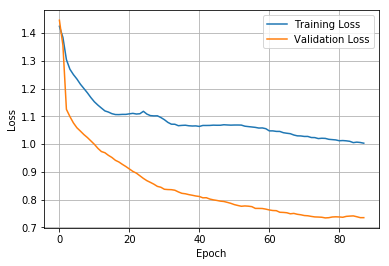

In [343]:
# training history
epoch_number = list(range((loss_train > 0.).sum()))
plt.figure()
plt.plot(epoch_number, loss_train[loss_train>0.],label='Training Loss')
plt.plot(epoch_number, loss_val[loss_train>0.],label='Validation Loss')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.grid(True)
plt.legend(loc='upper right')
#plt.savefig('%s/ROC.pdf'%(options.outputDir))
plt.show()

### Performances

In [344]:
lst = []
for j in torch.split(X_val, n_batches_val):
    a = gnn(j.cuda()).cpu().data.numpy()
    lst.append(a)
predicted = Variable(torch.FloatTensor(np.concatenate(lst)))

In [345]:
predicted.shape

torch.Size([24000, 5])

In [346]:
predicted = torch.nn.functional.softmax(predicted, dim=1)

In [347]:
predict_val = predicted.data.numpy()
true_val = Y_val.data.numpy()

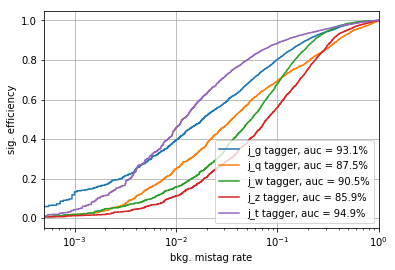

In [348]:
from sklearn.metrics import roc_curve, auc
#### get the ROC curves
fpr = {}
tpr = {}
auc1 = {}
plt.figure()
for i, label in enumerate(labels):
        fpr[label], tpr[label], threshold = roc_curve((true_val== i), predict_val[:,i])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(fpr[label],tpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
plt.semilogx()
plt.ylabel("sig. efficiency")
plt.xlabel("bkg. mistag rate")
plt.xlim(0.0005,1)
plt.grid(True)
plt.legend(loc='lower right')
#plt.savefig('%s/ROC.pdf'%(options.outputDir))
plt.show()

In [340]:
# SAVE DATA FRAMES in a new file
import pickle

with open('IN_ROC_%i_fpr.pickle' %nParticles, 'wb') as handle:
    pickle.dump(fpr, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('IN_ROC_%i_tpr.pickle' %nParticles, 'wb') as handle:
    pickle.dump(tpr, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('IN_ROC_%i_AUC.pickle' %nParticles, 'wb') as handle:
    pickle.dump(auc1, handle, protocol=pickle.HIGHEST_PROTOCOL)